In [1]:
# Tratamiento de datos
# ================================================================================================================
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ================================================================================================================
from sklearn.model_selection import PredefinedSplit, cross_validate, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Métricas
# ================================================================================================================
from sklearn.metrics import make_scorer, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import time
from sklearn.inspection import permutation_importance

# Gráficos
# ================================================================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# MLFLOW
# ================================================================================================================
import mlflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')

# Configuración warnings
# ================================================================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive') #.. era para salirse de la carpeta actual y entrar en la de drive
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

# Descargamos los datos en formato parquet de Google Drive
# guardar localmente
drive.descargar_archivos_concretos('maxEstratificado.parquet', '../drive')
#hay que pasarle la ruta a la carpeta drive desde donde lo estamos ejecutando
# y el nombre del archivo que hemos puesto en el archivos_info.txt (MLP_runs.db en nuestro ejemplo, en vez de datosEntrenamiento.parquet...)
# leer para utilizar esto ya en el modelo
data = pd.read_parquet('datos/maxEstratificado.parquet') # 
data

,name,EventStartTime,SalesStartTIme,SalesEndTime,min_price,nameArtist,VenueName,VenueCity,VenueState,num_links,...,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,fold
0,"30 Aniversario de Sôber, con Savia y Skizoo",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,28.0,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
1,"30 Aniversario de Sôber, con Savia y Skizoo | ...",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,50.0,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
2,AC/DC - Power Up Tour,2024-05-25 19:00:00+00:00,2024-01-31 11:00:00+00:00,2024-05-25 19:00:00+00:00,105.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,115,0,1,0
3,AC/DC - Power Up Tour,2024-05-29 19:30:00+00:00,2024-02-16 09:00:00+00:00,2024-05-29 19:30:00+00:00,105.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,103,0,1,0
4,AC/DC - Power Up Tour,2024-12-14 20:00:00+00:00,2024-03-01 11:00:00+00:00,2024-12-14 20:00:00+00:00,105.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,288,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,Yung Sarria,2024-03-30 20:00:00+00:00,2023-10-06 13:00:00+00:00,2024-03-30 20:00:00+00:00,12.0,Yung Sarria,Sala Shoko,Madrid,Madrid,0,...,0,0,1,0,0,0,176,0,1,3
490,ZENOBIA + DEBLER,2024-06-01 19:30:00+00:00,2024-02-20 09:00:00+00:00,2024-06-01 19:30:00+00:00,22.0,Zenobia,Sala Shoko,Madrid,Madrid,1,...,0,0,0,0,0,0,102,0,1,3
491,gREAT sTRAITS,2024-10-19 19:30:00+00:00,2024-01-02 11:00:00+00:00,2024-10-19 19:30:00+00:00,35.0,gREAT sTRAITS,Sala Razzmatazz 1,Barcelona,Barcelona,0,...,0,0,0,0,0,0,291,0,1,3
492,gREAT sTRAITS,2024-09-13 19:30:00+00:00,2023-12-22 09:00:00+00:00,2024-09-13 19:30:00+00:00,38.0,gREAT sTRAITS,La Riviera,Madrid,Madrid,0,...,0,0,0,0,0,0,266,0,1,3


Mostrar la dsitribución que sigue la variable objetivo min_price.

Text(0.5, 0, 'precio')

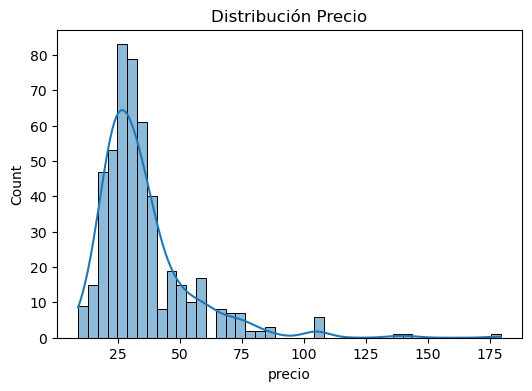

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.histplot(data=data, x='min_price', kde=True,ax=ax)
ax.set_title("Distribución Precio")
ax.set_xlabel('precio')

In [4]:
# Eliminamos las categoricas
columnas=['name','EventStartTime', 'SalesStartTIme', 'SalesEndTime', 'nameArtist', 'VenueName',
          'VenueCity', 'VenueState','Generos_combinados']

datos = data.drop(columnas, axis=1)

RANDOM_STATE = 83 #fijamos la semilla

# y es la variable objetivo 
X = datos.iloc[:,1:]
y = datos['min_price']

# Quitar la columna fold
X_train = X.iloc[:,:-1]

# Los atributos que necesitan un escalado
no_binarias = ['num_links', 'seguidoresSpotify', 'popularidad', 'subsYT', 'NumGeneros', 'peso_promotor',
               'conciertos_del_artista_en_ciudad', 'dias_Venta', 'dias_desdeFinVenta', 'num_noches']



Función que muestra un gráfico con las predicciones de un modelo y los valores reales del precio mínimo de un concierto.

In [5]:

def plot_model_predictions(mlp, X, y, datos1):
    # Entrenar el pipeline con el modelo
    mlp.fit(X, y)
    # Realiza las predicciones 
    predicciones = mlp.predict(X)

    # Crea un DataFrame con los precios reales, predichos y el nombre del concierto
    df = pd.DataFrame({'Nombre del Concierto': datos1['name'], 'Precio Real': y, 'Precio Predicho': predicciones})

    # Crea un scatter plot interactivo con Plotly
    fig = px.scatter(df, x='Precio Real', y='Precio Predicho', color='Nombre del Concierto',
                     title='Comparación de Precios Reales vs Precios Predichos',
                     labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

    # Agrega una línea diagonal que representa la igualdad entre los precios reales y predichos
    fig.add_shape(type='line',
                  x0=df['Precio Real'].min(), y0=df['Precio Real'].min(),
                  x1=df['Precio Real'].max(), y1=df['Precio Real'].max(),
                  line=dict(color='red', width=2, dash='dash'))
    
    fig.show()


Función que carga un modelo en MLFLOW. Recibe como parámetros el modelo, el nombre del experimento y el nombre del run.

In [6]:

def cargar_modelo_mlflow(mlp, experimento, run_name, results, time):
    
    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("results.csv", index=False)

    # Iniciar un nuevo run de MLflow
    with mlflow.start_run(run_name=run_name):

        # Configurar el experimento de MLflow
        mlflow.set_experiment(experimento)
        
        mlflow.log_param("random_state", RANDOM_STATE)
        mlflow.log_params(mlp.get_params())
        mlflow.log_metric("execution_time", time)
        
        mlflow.sklearn.log_model(mlp, "model")
        
        # Registrar el archivo CSV en MLflow
        mlflow.log_artifact("results.csv", "results")

    mlflow.end_run()


Para analizar las varaibles que entrna en juego se usará el método Permutation feature importance de la biblioteca sklearn. Esta técnica mide la contribución de cada característica al rendimiento del modelo. Para ello, se se barajan aleatoriamente los valores de cada característica y se mide la disminución en el rendiemiento del modelo. Las características con mayor importancia causan una mayor disminución en la métrica de evaluación cuando son permutadas.


In [7]:
def feature_importance(pipeline, X, y, top_n, random_state=RANDOM_STATE):
    pipeline.fit(X, y)  # Entrenadr el modelo

    # Calcular la importancia de las características
    importance = permutation_importance(pipeline, X, y, n_repeats=30, random_state=random_state, scoring='neg_mean_squared_error')

    feature_names = X.columns
    sorted_idx = importance.importances_mean.argsort()[::-1]  # Ordenar de mayor a menor

    # Seleccionar los top_n más importantes
    top_features = sorted_idx[:top_n]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importance.importances_mean[top_features], y=feature_names[top_features], palette="viridis")
    plt.xlabel("Importancia de la característica (promedio de reducción de score)", fontsize=10)
    plt.ylabel("Características", fontsize=10)
    plt.title(f"Top {top_n} características más importantes usando Permutation Feature Importance", fontsize=10)
    
    # Añadir etiquetas de los valores en las barras
    for index, value in enumerate(importance.importances_mean[top_features]):
        plt.text(value, index, f'{value:.2f}', va='center', ha='right', color='black', fontsize=8)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().invert_yaxis()  # Invertir el eje y para que el más importante esté en la parte superior
    plt.tight_layout()
    plt.show()



Como para todos los modelos se usará el método cross_validate se implementa una función para que muestre los resultados en el fomato deseado.

In [8]:

def crear_tabla_resultados(resultados):
    # Crear un DataFrame con los resultados de validación cruzada
    df = pd.DataFrame(resultados)
    
    # Calcular promedios
    promedio = df.mean()
    
    # Crear DataFrame con las métricas
    df_sin_promedio = pd.DataFrame({
        'Test Fold': range(0, len(resultados['test_MAPE'])),
        'MAPE Train': resultados['train_MAPE'],
        'RMSE Train': resultados['train_RMSE'],
        'MSE Train': resultados['train_MSE'],
        'MAE Train': resultados['train_MAE'],
        'MAPE Val': resultados['test_MAPE'],
        'RMSE Val': resultados['test_RMSE'],
        'MSE Val': resultados['test_MSE'],
        'MAE Val': resultados['test_MAE']
    })
    
    # Añadir los promedios
    df_promedio = pd.DataFrame({
        'Test Fold': ['Promedio'],
        'MAPE Train': promedio['train_MAPE'],
        'RMSE Train': promedio['train_RMSE'],
        'MSE Train': promedio['train_MSE'],
        'MAE Train': promedio['train_MAE'],
        'MAPE Val': promedio['test_MAPE'],
        'RMSE Val': promedio['test_RMSE'],
        'MSE Val': promedio['test_MSE'],
        'MAE Val': promedio['test_MAE']
    }, index=[len(resultados['test_MAPE'])]) 
    
    # Concatenar los DataFrames
    df_final = pd.concat([df_sin_promedio, df_promedio])

    return df_final

En todos los modelos se hará un escalado de las variables que no son binarias. En cada iteración de cross validate se hará el fit_transform del escalado con los datos de entrenamiento para aplicarlo después a los datos de test. Para lograrlo se crea un objeto Pipeline que permite encadenar el escalado y después el modelo. 

In [9]:

ps = PredefinedSplit(datos['fold'])

mlp = MLPRegressor(random_state=RANDOM_STATE)

# Definir el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), no_binarias)
    ],
    remainder='passthrough'  # Deja las otras columnas sin cambios
)

# Definir el pipeline con el ColumnTransformer y el modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(random_state=RANDOM_STATE))
])

# Definir las métricas personalizados 
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'MAE': make_scorer(mean_absolute_error),
    'MAPE': make_scorer(mean_absolute_percentage_error)
}

MODELO BASE REDES NEURONALES SIN ESTADARIZAR

Tiempo de ejecución:  2.049647092819214 segundos


2024/06/10 17:51:39 INFO mlflow.tracking.fluent: Experiment with name 'MIN_PRICE' does not exist. Creating a new experiment.


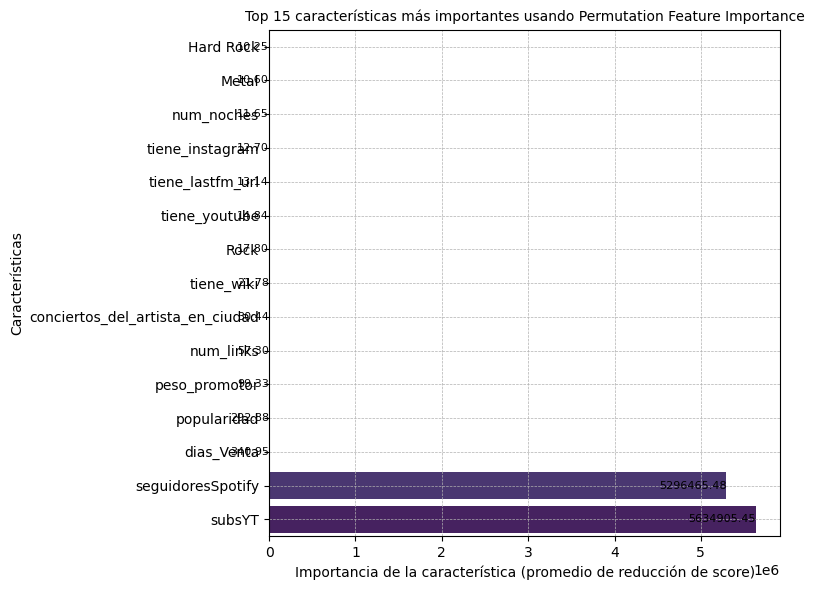

,Test Fold,MAPE Train,RMSE Train,MSE Train,MAE Train,MAPE Val,RMSE Val,MSE Val,MAE Val
0,0,22.438312,1670.284731,2.789851e+06,818.093382,27.829767,4178.485084,1.745974e+07,1407.772630
1,1,16.106305,1481.911739,2.196062e+06,646.005521,12.581931,1288.741317,1.660854e+06,493.396621
2,2,28.193988,2331.795251,5.437269e+06,1030.775161,55.189266,6824.424859,4.657277e+07,3249.762230
3,3,22.180773,1828.529778,3.343521e+06,864.810053,56.494302,14843.416021,2.203270e+08,2552.443088
4,Promedio,22.229845,1828.130375,3.441676e+06,839.921029,38.023817,6783.766820,7.150509e+07,1925.843642


In [10]:

start_time = time.time()

results = cross_validate(mlp, X_train, y, cv=ps, scoring=scoring, return_train_score=True)

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución: ", execution_time, "segundos")

resultados = crear_tabla_resultados(results)

# Cargar el modelo en MLFLOW
cargar_modelo_mlflow(mlp, 'MIN_PRICE', 'BASE SIN ESTANDARIZAR', resultados, execution_time)

# Mostrar las predicciones y los valores reales
plot_model_predictions(mlp, X_train, y, data)
feature_importance(mlp, X_train, y, 15)
resultados


MODELO BASE REDES NEURONALES - ESTANDARIZADO

Tiempo de ejecución: 2.1599297523498535 segundos


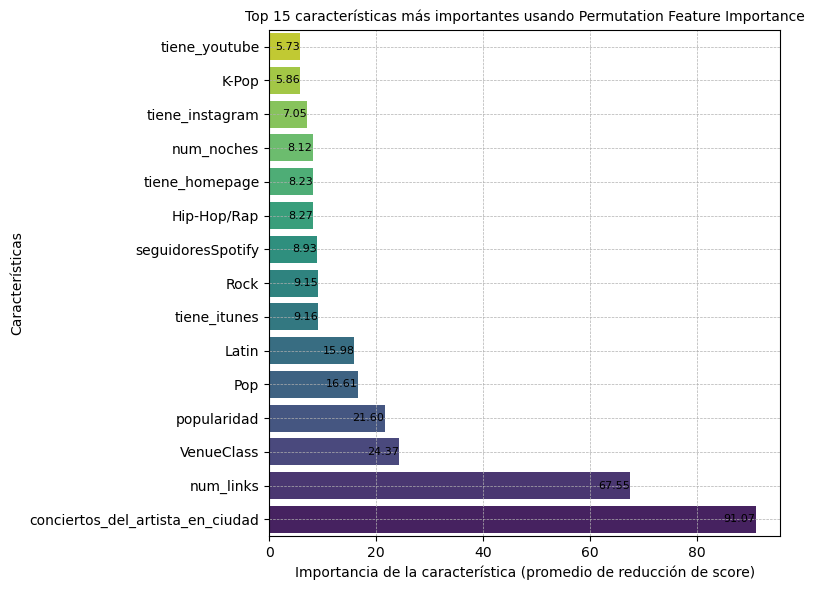

,Test Fold,MAPE Train,RMSE Train,MSE Train,MAE Train,MAPE Val,RMSE Val,MSE Val,MAE Val
0,0,0.219982,12.757430,162.752009,7.837223,0.277618,13.164915,173.314986,9.189869
1,1,0.233981,13.299646,176.880587,8.477215,0.302028,12.366751,152.936522,8.657923
2,2,0.219423,11.100489,123.220848,7.073857,0.221880,19.273106,371.452601,11.097128
3,3,0.204844,11.560842,133.653064,7.250375,0.303963,18.064570,326.328675,10.449172
4,Promedio,0.219558,12.179602,149.126627,7.659668,0.276372,15.717335,256.008196,9.848523


In [11]:

# Medir el tiempo de ejecución de la validación cruzada
start_time = time.time()

# Ejecutar la validación cruzada
results = cross_validate(pipeline, X_train, y, cv=ps, scoring=scoring, return_train_score=True)

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución:", execution_time, "segundos")

resultados = crear_tabla_resultados(results)

# Cargar el modelo en MLFLOW
cargar_modelo_mlflow(pipeline, 'MIN_PRICE', 'BASE ESTANDARIZADO', resultados, execution_time)

# Mostrar las predicciones y los valores reales
plot_model_predictions(pipeline, X_train, y, data)
feature_importance(pipeline, X_train, y, 15)
resultados

MODELO GRID SEARCH SIN ESTANDARIZAR

Tiempo de ejecución: 290.3415629863739 segundos
Mejores parámetros GridSearchCV:  {'activation': 'tanh', 'hidden_layer_sizes': 100, 'solver': 'sgd'}


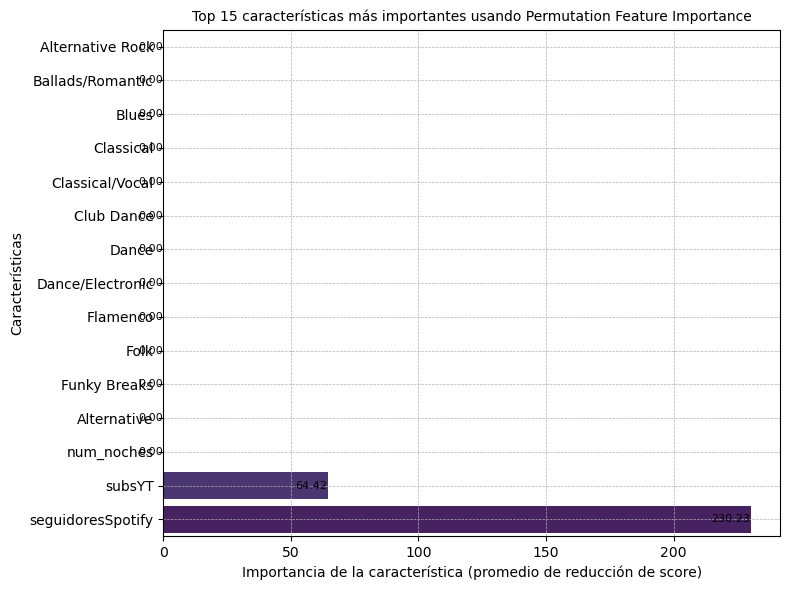

,Test Fold,MAPE Train,RMSE Train,MSE Train,MAE Train,MAPE Val,RMSE Val,MSE Val,MAE Val
0,0,0.317902,16.102297,259.283965,10.445788,0.361576,17.432243,303.883089,11.924223
1,1,0.344535,16.548584,273.855633,11.146195,0.435015,16.318564,266.295517,11.547611
2,2,0.345645,14.853669,220.631485,10.355858,0.261526,21.605479,466.796726,12.740783
3,3,0.311328,16.265594,264.569543,10.383309,0.442359,17.426949,303.698542,12.746552
4,Promedio,0.329853,15.942536,254.585157,10.582787,0.375119,18.195809,335.168469,12.239792


In [12]:

# Definir los parámetros para GridSearchCV
params = {
    'hidden_layer_sizes': [1, 50, 75, 100, 125, 150, 200, 225, 250, 275, 300, 325, 350, 375, 400],
    'activation': ["identity", "logistic", "tanh", "relu"],
    'solver': ['lbfgs', 'sgd', 'adam']
}

# Realizar GridSearchCV
start_time = time.time()

gridSearch = GridSearchCV(estimator=mlp, param_grid=params, n_jobs=-1, scoring='neg_mean_squared_error', cv=ps)
gridSearch.fit(X_train, y)
results = cross_validate(gridSearch.best_estimator_, X_train, y, cv=ps, scoring=scoring, return_train_score=True)

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución:", execution_time, "segundos")

print('Mejores parámetros GridSearchCV: ', gridSearch.best_params_)

resultados = crear_tabla_resultados(results)

cargar_modelo_mlflow(gridSearch.best_estimator_, 'MIN_PRICE', 'GRID SEARCH SIN ESTANDARIZAR', resultados, execution_time)

# Mostrar las predicciones y los valores reales
plot_model_predictions(gridSearch.best_estimator_, X_train, y, data)
feature_importance(gridSearch.best_estimator_, X_train, y, 15)
resultados

MODELO GRID SEARCH ESTANDARIZADO

Tiempo de ejecución: 278.3950262069702 segundos
Mejores parámetros GridSearchCV:  {'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': 400, 'mlp__solver': 'adam'}


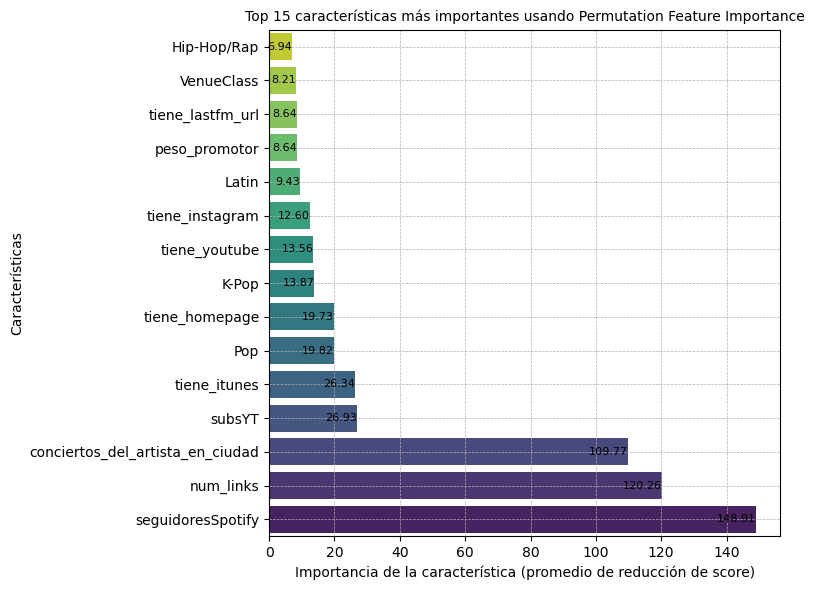

,Test Fold,MAPE Train,RMSE Train,MSE Train,MAE Train,MAPE Val,RMSE Val,MSE Val,MAE Val
0,0,0.196115,11.858157,140.615899,6.951970,0.323537,13.557368,183.802214,9.632001
1,1,0.192928,12.278814,150.769283,7.193358,0.296010,10.495381,110.153032,8.057435
2,2,0.195628,10.069097,101.386715,6.373067,0.212260,19.346196,374.275287,10.370370
3,3,0.182647,11.251792,126.602816,6.551853,0.265934,13.733351,188.604939,8.901305
4,Promedio,0.191830,11.364465,129.843678,6.767562,0.274435,14.283074,214.208868,9.240278


In [13]:
# Definir los parámetros para GridSearchCV
params = {
    'mlp__hidden_layer_sizes': [1, 50, 75, 100, 125, 150, 200, 225, 250, 275, 300, 325, 350, 375, 400],
    'mlp__activation': ["identity", "logistic", "tanh", "relu"],
    'mlp__solver': ['lbfgs', 'sgd', 'adam']
}

# Realizar GridSearchCV
start_time = time.time()

gridSearch = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, scoring='neg_mean_squared_error', cv=ps)
gridSearch.fit(X_train, y)

results = cross_validate(gridSearch.best_estimator_, X_train, y, cv=ps, scoring=scoring, return_train_score=True)

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución:", execution_time, "segundos")

print('Mejores parámetros GridSearchCV: ', gridSearch.best_params_)

resultados = crear_tabla_resultados(results)

cargar_modelo_mlflow(gridSearch.best_estimator_, 'MIN_PRICE', 'GRID SEARCH ESTANDARIZADO', resultados, execution_time)

# Mostrar las predicciones y los valores reales
plot_model_predictions(gridSearch.best_estimator_, X_train, y, data)
feature_importance(gridSearch.best_estimator_, X_train, y, 15)
resultados

RANDOM SEARCH SIN ESTANDARIZAR

Tiempo de ejecución:  265.69046807289124 segundos
Mejores parámetros RandomSearch:  {'solver': 'lbfgs', 'hidden_layer_sizes': 123, 'activation': 'logistic'}


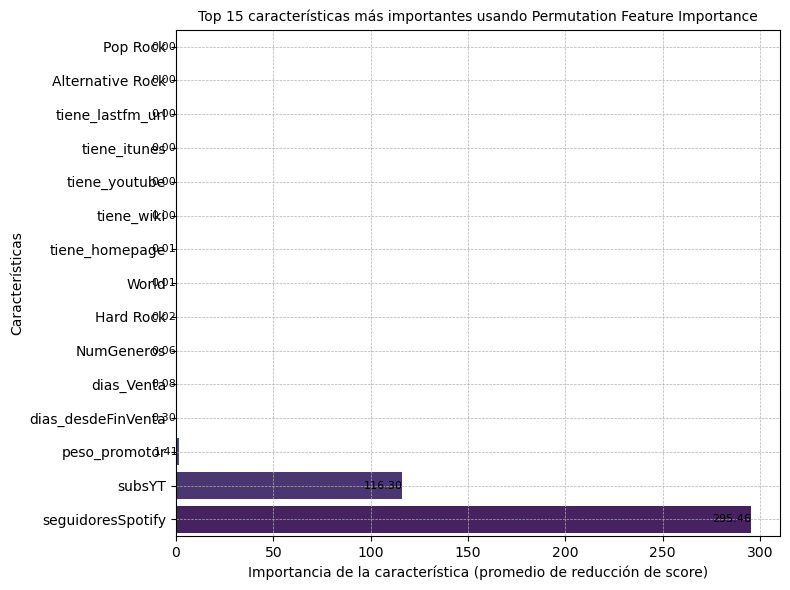

,Test Fold,MAPE Train,RMSE Train,MSE Train,MAE Train,MAPE Val,RMSE Val,MSE Val,MAE Val
0,0,0.344762,16.008426,256.269717,11.042949,0.393520,17.266882,298.145202,12.328236
1,1,0.349894,17.173509,294.929396,11.496052,0.413036,15.889871,252.487998,11.294582
2,2,0.357125,15.248612,232.520176,10.798053,0.337966,23.378947,546.575171,15.926776
3,3,0.268008,13.313185,177.240900,8.882743,0.427050,17.696156,313.153922,12.718707
4,Promedio,0.329948,15.435933,240.240047,10.554949,0.392893,18.557964,352.590573,13.067075


In [14]:

# Definir los parámetros para Random Search
params = {
    'hidden_layer_sizes': range(1, 401),
    'activation': ["relu", "identity",  "tanh", "logistic"],
    'solver': ['sgd', 'lbfgs', 'adam'],
}
# 15*4*3 combinaciones = 180

# Realizar Random Search
start_time = time.time()

randomSearch = RandomizedSearchCV(estimator=mlp, param_distributions=params, n_iter=180, n_jobs=-1, scoring='neg_mean_squared_error', cv=ps)
randomSearch.fit(X_train, y)

results = cross_validate(randomSearch.best_estimator_, X_train, y, cv=ps, scoring=scoring, return_train_score=True)

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución: ", execution_time, "segundos")

print('Mejores parámetros RandomSearch: ', randomSearch.best_params_)

resultados = crear_tabla_resultados(results)

cargar_modelo_mlflow(randomSearch.best_estimator_, 'MIN_PRICE', 'RANDOM SEARCH SIN ESTANDARIZAR', resultados, execution_time)

# Mostrar las predicciones y los valores reales
plot_model_predictions(randomSearch.best_estimator_, X_train, y, data)
feature_importance(randomSearch.best_estimator_, X_train, y, 15)
resultados


RANDOM SEARCH ESTANDARIZADO

Tiempo de ejecución: 262.0541236400604 segundos
Mejores parámetros RandomSearch:  {'mlp__solver': 'adam', 'mlp__hidden_layer_sizes': 392, 'mlp__activation': 'tanh'}


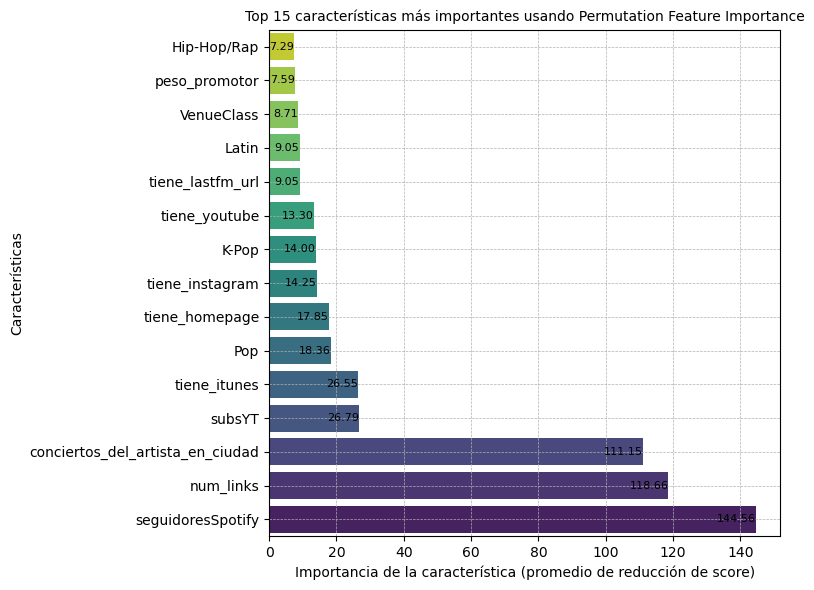

,Test Fold,MAPE Train,RMSE Train,MSE Train,MAE Train,MAPE Val,RMSE Val,MSE Val,MAE Val
0,0,0.197660,11.936231,142.473611,7.014774,0.325513,13.573226,184.232472,9.691924
1,1,0.195411,12.388315,153.470352,7.285934,0.298835,10.679241,114.046191,8.172836
2,2,0.198098,10.154756,103.119070,6.453022,0.212400,19.375577,375.412971,10.399628
3,3,0.185198,11.382090,129.551968,6.652601,0.265138,13.697202,187.613332,8.895517
4,Promedio,0.194092,11.465348,132.153750,6.851583,0.275472,14.331311,215.326241,9.289976


In [15]:

# Definir los parámetros para Random Search
params = {
    'mlp__hidden_layer_sizes': range(1, 401),
    'mlp__activation': ["relu", "identity",  "tanh", "logistic"],
    'mlp__solver': ['sgd', 'lbfgs', 'adam'],
}

# Realizar Random Search
start_time = time.time()

randomSearch = RandomizedSearchCV(estimator=pipeline, param_distributions=params, n_iter=180, n_jobs=-1, scoring='neg_mean_squared_error', cv=ps)
randomSearch.fit(X_train, y)

results = cross_validate(randomSearch.best_estimator_, X_train, y, cv=ps, scoring=scoring, return_train_score=True)

end_time = time.time()
execution_time = end_time - start_time
print("Tiempo de ejecución:", execution_time, "segundos")

print('Mejores parámetros RandomSearch: ', randomSearch.best_params_)

resultados = crear_tabla_resultados(results)

cargar_modelo_mlflow(randomSearch.best_estimator_, 'MIN_PRICE', 'RANDOM SEARCH ESTANDARIZADO', resultados, execution_time)

# Mostrar las predicciones y los valores reales
plot_model_predictions(randomSearch.best_estimator_, X_train, y, data)
feature_importance(randomSearch.best_estimator_, X_train, y, 15)
resultados


Análisis por segemntos. Para este análisis de segmentos nos fijamos en el atributo venue_class. De manera que tendremos 4 segmentos que estudiar individualmente. Estos son 0 = sala, 1 = teatro, 2 = estadio s y 3 = estadio M. Registraremos ahora las métricas para los 4 segementos usando el mejor modelo: random search y podremos ver si hay algún venue_class que se clasifique mejor o peor.

In [16]:

# Definir los parámetros
params = {
    'hidden_layer_sizes': (379,),
    'activation': "tanh",
    'solver': 'adam'
}

# Los atributos que necesitan un escalado
no_binarias = ['num_links', 'seguidoresSpotify', 'popularidad', 'subsYT', 'NumGeneros', 'peso_promotor',
               'conciertos_del_artista_en_ciudad', 'dias_Venta', 'dias_desdeFinVenta', 'num_noches']

# Crear el column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), no_binarias)
    ],
    remainder='passthrough'  # Deja las demás columnas sin cambios
)

# Crear el pipeline con los pasos de preprocesamiento y el modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(random_state=RANDOM_STATE, **params))
])


pipeline.fit(X_train, y)

y_pred = pipeline.predict(X_train)

# Copiar el DataFrame original
datos_segmentos = datos.copy()
# Añadir las predicciones al DataFrame
datos_segmentos['pred'] = y_pred

# Crear una lista para almacenar los resultados
resultados_list = []

# Calcular las métricas para cada valor de "VenueClass"
for vc in datos['VenueClass'].unique():
    subset = datos_segmentos[datos_segmentos['VenueClass'] == vc]
    mse = mean_squared_error(subset['min_price'], subset['pred'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(subset['min_price'], subset['pred'])
    resultados_list.append({'VenueClass': vc, 'mse': mse, 'rmse': rmse, 'mape': mape})

# Convertir la lista de resultados en un DataFrame
resultados = pd.DataFrame(resultados_list)
resultados

,VenueClass,mse,rmse,mape
0,2,121.546062,11.024793,0.174891
1,3,222.547017,14.918010,0.240599
2,1,109.048610,10.442634,0.175104
3,0,119.777091,10.944272,0.190545


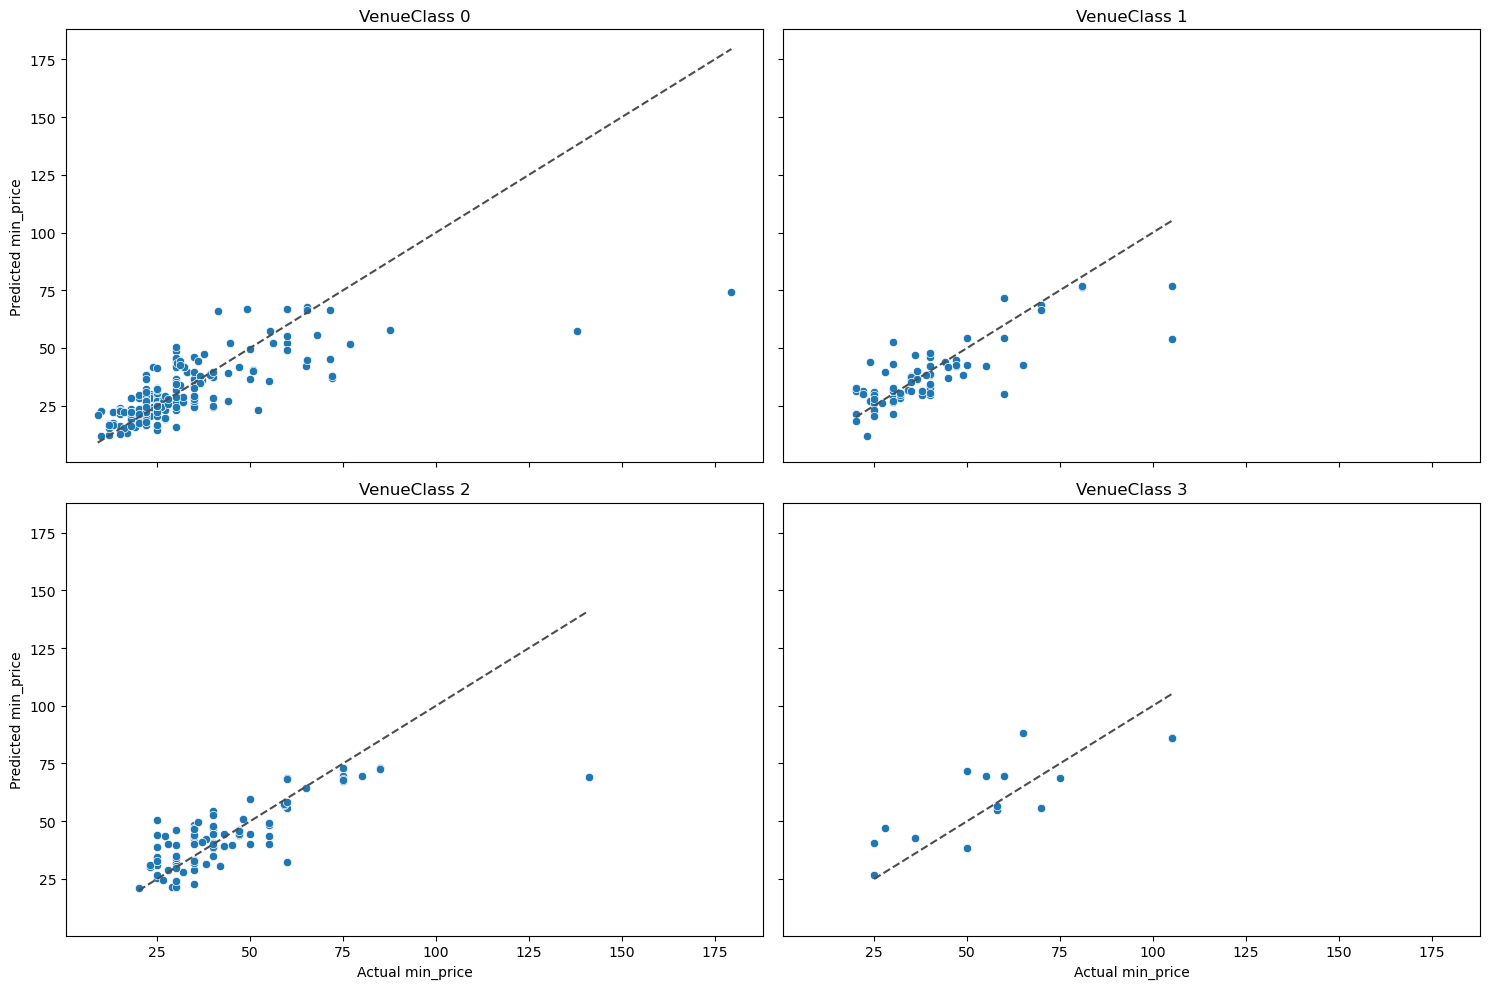

In [17]:

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

# Ordenar los datos
venue_classes = sorted(datos_segmentos['VenueClass'].unique())

for idx, vc in enumerate(venue_classes):
    subset = datos_segmentos[datos_segmentos['VenueClass'] == vc]
    ax = axes[idx//2, idx%2]  # Ubicación del gráfico en la cuadrícula
    sns.scatterplot(ax=ax, x=subset['min_price'], y=subset['pred'])
    ax.plot([subset['min_price'].min(), subset['min_price'].max()],
            [subset['min_price'].min(), subset['min_price'].max()],
            ls="--", c=".3")
    ax.set_title(f'VenueClass {vc}')
    ax.set_xlabel('Actual min_price')
    ax.set_ylabel('Predicted min_price')

plt.tight_layout()
plt.show()
